This notebook is used to train a classifier neural network algorithm using inputs generated from the `nn_create_inputs.py` script.

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras.callbacks import EarlyStopping
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import h5py
from pickle import dump

from keras import backend as K

# from pandas import DataFrame, plotting

from Analysis_Helper import calculate_deltaR, change_cmap_bkg_to_white

import matplotlib.colors as colors
import matplotlib.cm as cm
cmap = 'rainbow'
cmap = change_cmap_bkg_to_white(cmap)

Using TensorFlow backend.


In [2]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 7)

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Neural Network Hyperparameters
Tuning of the neural network can be done by modifying these values

In [13]:
inputs_filename = '/eos/user/s/srosenzw/SWAN_projects/sixB/Machine_Learning/Inputs/MX700_MY400_classifier_allpairs_dR_presel.npz'
# MX_MY = inputs_filename[16:27]
# mx, my = MX_MY.split('_')
# MX, MY = mx[2:], my[2:]
# suffix = inputs_filename[27:-4] #+ '_reducedto10pc'

# print(f"Training model for MX = {MX} GeV and MY = {MY} GeV")

In [9]:
# Input hyperparameters
input_activation = 'selu'

# Hidden hyperparameters
# nodes = [32,64,64,128,512,128,64,64,32]
nodes = [12,8,4]
hidden_activations = ['selu'] * len(nodes)
assert(len(nodes) == len(hidden_activations))
num_hidden = len(nodes)

# Output hyperparameters
output_activation = 'sigmoid'
output_nodes = 1

# Fitting hyperparameters
optimizer = 'nadam'
loss_function = 'binary_crossentropy'
num_epochs = 100
batch_size = 500

# # Saving options
# folder = 'NN_models/' + MX_MY + '/' 
# plots = folder + 'plots/' # Change this for new runs

# # Create folders if they don't already exist
# if not os.path.exists(folder):
#     os.makedirs(folder)
# if not os.path.exists(plots):
#     os.makedirs(plots)

# filesave = folder + MX_MY + suffix

# print(f"Files will be saved in location:\n{filesave}")

# Load Inputs
Inputs are loaded from .npz file. Later tests can compare file size for numpy arrays and Pandas dataframes.

In [14]:
# Load inputs
inputs = np.load(inputs_filename)

# Define parameters
X = inputs['x']
X_excess = inputs['extra_bkgd_x']
input_nodes = np.shape(X)[1]

# Define output
y = inputs['y']
y_excess = inputs['extra_bkgd_y']

# Used to compare score with dijet invariant mass
mjj = inputs['mjj'] # GeV
mjj_excess = inputs['extra_bkgd_mjj'] # GeV

In [ ]:
def apply_stat_power_curve_analysis(X, y, mjj, percentage):
    X, _, y, _, m, _ = train_test_split(X, y, mjj, test_size=1-percentage, random_state=42)
    return X, y, m

In [ ]:
X_red, y_red, mjj_red = apply_stat_power_curve_analysis(X, y, mjj, 0.10)

In [ ]:
true_Higgs_mask = (y == 1)

mbb_Higgs_pairs = mjj[true_Higgs_mask]
mjj_background = mjj[~true_Higgs_mask]

Perform a sanity check to make sure the inputs reconstruct the Higg mass.

In [ ]:
# Determination of baseline (target) efficiency.

# Suppose the algorithm is learning the mass of the Higgs pairs.
# What kind of efficiency can we expect in the worst case scenario?

min_tol = np.min(mbb_Higgs_pairs)
max_tol = np.max(mbb_Higgs_pairs)

fake_mask = (mjj_background > min_tol) & (mjj_background < max_tol)

baseline_efficiency = (len(mbb_Higgs_pairs) + len(mjj_background[fake_mask])) / len(mjj) * 100

print(f"Baseline efficiency: {baseline_efficiency:.2f}%")

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle("Verification that True Higgs pairs have Higgs mass")

ax = axs[0]
bins = np.linspace(np.min(mjj),  np.max(mjj), 100)
n, bins, _ = ax.hist(mbb_Higgs_pairs, histtype='step', align='mid', bins=bins, label='Higgs Pairs')
ax.hist(mjj_background, histtype='step', align='mid', bins=bins, label='Combinatoric Backround Pairs')
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'$m_{jj}$ [GeV]')
ax.legend()

ax = axs[1]
bins = np.linspace(np.min(X[:,-1]),  np.max(X[:,-1]), 100)
n, bins, _ = ax.hist(X[:,-1][y==1], histtype='step', align='mid', bins=bins, label='Higgs Pairs')
ax.hist(X[:,-1][y==0], histtype='step', align='mid', bins=bins, label='Combinatoric Backround Pairs')
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'$\Delta R$')
ax.legend(loc='lower center')

plt.show()

# Input Size Experiment

In [ ]:
# X = X[:,:-1]
# X_excess = X_excess[:,:-1]

In [ ]:
# np.shape(X)

In [ ]:
# three_H_inputs = np.vstack((X[0::6,:], X[1::6,:], X[2::6,:]))
# three_H_class = np.concatenate((y[0::6], y[1::6], y[2::6]))
# three_H_mjj = np.concatenate((mjj[0::6], mjj[1::6], mjj[2::6]))

# three_nonH_inputs = np.vstack((X[3::6,:], X[4::6,:], X[5::6,:]))
# three_nonH_class = np.concatenate((y[3::6], y[4::6], y[5::6]))
# three_nonH_mjj = np.concatenate((mjj[3::6], mjj[4::6], mjj[5::6]))

# Scale and Split Data

In [15]:
xscaler = MinMaxScaler()
xscaler.fit(np.vstack((X, X_excess)))
xnormalized = xscaler.transform(X)
xinverse = xscaler.inverse_transform(xnormalized)
dump(xscaler, open(filesave + '_scaler.pkl', 'wb'))

test_size = 0.20
val_size = 0.125
X_train, X_test, x_train, x_test, y_train, y_test, _, m_test = train_test_split(X, xnormalized, y, mjj, test_size=0.20, random_state=42)
X_train, X_val, x_train, x_val, y_train, y_val = train_test_split(X_train, x_train, y_train, test_size=0.125, random_state=42)

print("Training set:   ", len(x_train))
print("Validation set: ", len(x_val))
print("Testing set:    ", len(x_test))

# The proportions of "successes" in split datasets
eps = 5e-3
class1 = np.sum(y_train)/len(x_train)
class0 = 1 - class1 

assert(abs(np.sum(y_train)/len(x_train) - 0.5) < eps)
assert(abs(np.sum(y_test)/len(x_test) - 0.5) < eps)
assert(abs(np.sum(y_val)/len(x_val) - 0.5) < eps)

param_dim = np.shape(x_train)[1]
print("Input parameters:",param_dim) # Use this as a guide for how many nodes to use in hidden layers

Training set:    219975
Validation set:  31425
Testing set:     62850
Input parameters: 8


In [ ]:
len(x_train)+len(x_val)+len(x_test)

# Define Model

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
# define the keras model
model = Sequential()

# Input layers
model.add(Dense(input_nodes, input_dim=param_dim, activation=input_activation))

# Hidden layers
for i in range(num_hidden):
    model.add(Dense(nodes[i], activation=hidden_activations[i]))

# Output layer
model.add(Dense(output_nodes, activation=output_activation))

W0127 17:13:13.706813 140116202653504 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0127 17:13:13.737582 140116202653504 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0127 17:13:13.742597 140116202653504 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0127 17:13:13.767904 140116202653504 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64

In [18]:
# modify and compile the keras model
optimizer = keras.optimizers.Nadam()

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

lr_metric = get_lr_metric(optimizer)

es = EarlyStopping(monitor='loss', restore_best_weights=True)

model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy', lr_metric])

W0127 17:13:13.893661 140116202653504 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0127 17:13:13.902475 140116202653504 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.



# Train Model

In [19]:
# fit the keras model on the dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                    epochs=num_epochs, batch_size=batch_size, callbacks=[es])

W0127 17:13:17.660585 140116202653504 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 219975 samples, validate on 31425 samples
Epoch 1/100
219975/219975 [==============================] - 3s 14us/step - loss: 0.5593 - acc: 0.7203 - lr: 0.0020 - val_loss: 0.5151 - val_acc: 0.7435 - val_lr: 0.0020
Epoch 2/100
219975/219975 [==============================] - 2s 10us/step - loss: 0.4630 - acc: 0.7840 - lr: 0.0020 - val_loss: 0.3975 - val_acc: 0.8231 - val_lr: 0.0020
Epoch 3/100
219975/219975 [==============================] - 2s 9us/step - loss: 0.3713 - acc: 0.8389 - lr: 0.0020 - val_loss: 0.3572 - val_acc: 0.8471 - val_lr: 0.0020
Epoch 4/100
219975/219975 [==============================] - 2s 9us/step - loss: 0.3430 - acc: 0.8531 - lr: 0.0020 - val_loss: 0.3442 - val_acc: 0.8520 - val_lr: 0.0020
Epoch 5/100
219975/219975 [==============================] - 2s 9us/step - loss: 0.3051 - acc: 0.8724 - lr: 0.0020 - val_loss: 0.2800 - val_acc: 0.8854 - val_lr: 0.0020
Epoch 6/100
219975/219975 [==============================] - 2s 8us/step - loss: 0.2596 - acc: 0.8984 

In [20]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# Get training and test accuracy histories
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

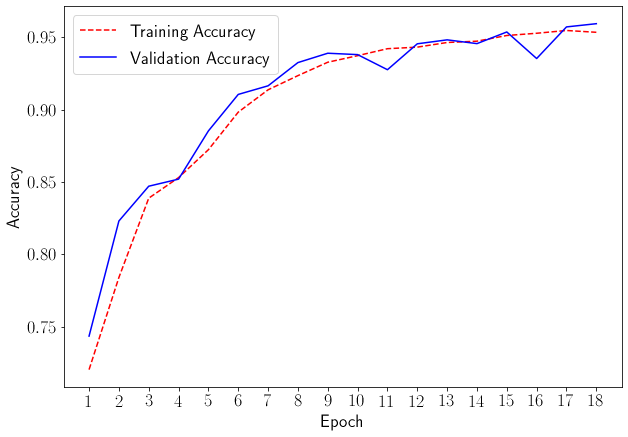

<Figure size 720x504 with 0 Axes>

In [22]:
epoch_count = range(1, len(training_accuracy) + 1)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epoch_count)
plt.show()

plt.tight_layout()

In [23]:
# Get training and test accuracy histories
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

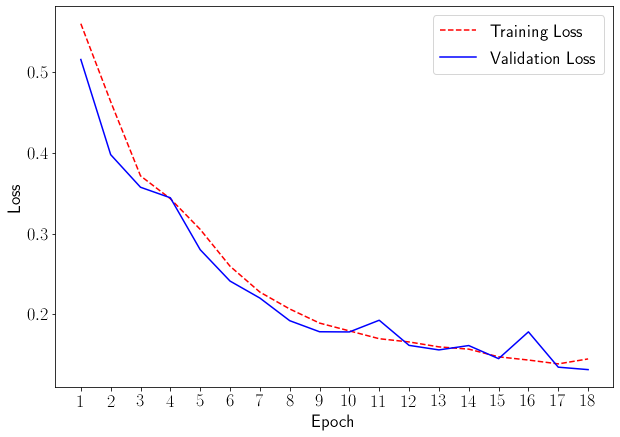

<Figure size 720x504 with 0 Axes>

In [24]:
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_count)
plt.show()

plt.tight_layout()

## Save Model

In [ ]:
model_json = model.to_json()
with open(filesave + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(filesave + ".h5")
print("Saved model to disk")

# Performance Evalution

In [26]:
y_pred_test = np.ravel(model.predict(x_test))

In [27]:
# evaluate the keras model
# model.evalute returns the loss and any metric values passed during compilation
loss, accuracy, learning_rate = model.evaluate(x_test, y_pred_test)

62850/62850 [==============================] - 2s 25us/step


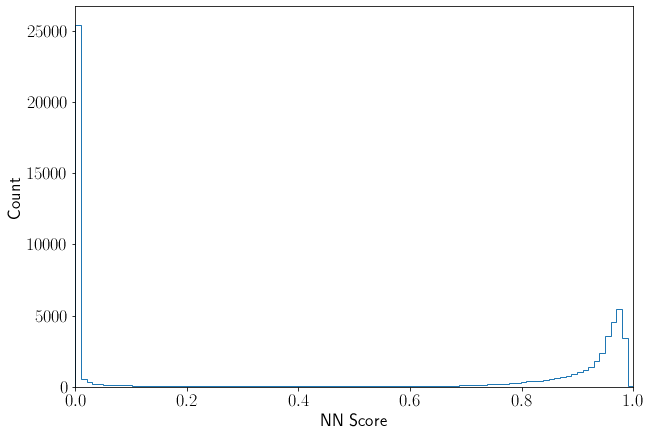

In [28]:
pred_bins = np.linspace(0,1,100)

fig, ax = plt.subplots()
# fig.suptitle("Distribution of NN output for test set")
n, pred_bins, _ = ax.hist(y_pred_test, histtype='step', align='mid', bins=pred_bins)
# plt.yscale('log')
plt.ylabel('Count')
plt.xlabel(r'NN Score')
plt.xlim(0,1)

plt.show()

fig.savefig(plots + "discriminator_distribution.pdf")

In [ ]:
true_Higgs_test_mask = (y_test == 1)

true_Higgs_pred = y_pred_test[true_Higgs_test_mask]
true_non_Higgs_pred = y_pred_test[~true_Higgs_test_mask]

non_Higgs_test_m = m_test[~true_Higgs_test_mask]
Higgs_test_m = m_test[true_Higgs_test_mask]

In [ ]:
true_positives = np.array(()) # Higgs pairs classified as Higgs pairs :)
true_negatives = np.array(()) # Non-Higgs pairs classified as non-Higgs pairs :)
false_positives = np.array(()) # Non-Higgs pairs classified as Higgs pairs :(
false_negatives = np.array(()) # Higgs pairs classified as non-Higgs pairs

cuts = np.linspace(0,1,100)
for cut in cuts:
    true_positives = np.append(true_positives, np.sum((y_test == 1) & (y_pred_test > cut))/len(y_test))
    true_negatives = np.append(true_negatives, np.sum((y_test == 0) & (y_pred_test < cut))/len(y_test))
    false_positives = np.append(false_positives, np.sum((y_test == 0) & (y_pred_test > cut))/len(y_test))
    false_negatives = np.append(false_negatives, np.sum((y_test == 1) & (y_pred_test < cut))/len(y_test))

In [ ]:
sensitivity = true_positives / (false_positives + true_positives)
specificity = true_negatives / (true_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

# Accuracy

In [ ]:
acc = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

In [ ]:
# fig = plt.figure(1)
# plt.title('Accuracy')
# plt.plot(cuts, acc)
# plt.xlabel('NN Score')
# plt.ylabel('Accuracy')
# plt.ylim(0,1)

# # fig1.savefig(plots + "ROC_curve.pdf")

# plt.show()

## F1 Curve

In [ ]:
f1_score = 2*1/(1/precision + 1/recall)

In [ ]:
# fig = plt.figure(1)
# # plt.plot([0, 1], [0, 1], 'k--')
# plt.title('F1 Score')
# plt.plot(cuts, f1_score)
# plt.xlabel('NN Score')
# plt.ylabel('F1 Score')
# # plt.legend(loc='best')

# # fig1.savefig(plots + "ROC_curve.pdf")

# plt.show()

## ROC Curve 

In [ ]:
fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred_test)
nn_auc = auc(fpr, tpr)

In [ ]:
fig1 = plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(nn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)

fig1.savefig(plots + "ROC_curve.pdf")

plt.show()

In [ ]:
total = len(Higgs_test_m)
mislabelled_Higgs = np.array(())

cuts = np.linspace(0,1,100)
for cut in cuts:
    mislabelled_Higgs = np.append(mislabelled_Higgs, len(Higgs_test_m[true_Higgs_pred < cut]))
mislabelled_Higgs = mislabelled_Higgs / total


total = len(non_Higgs_test_m)
fake_Higgs = np.array(())

cuts = np.linspace(0,1,100)
for cut in cuts:
    fake_Higgs = np.append(fake_Higgs, len(non_Higgs_test_m[true_non_Higgs_pred > cut]))
    
fake_Higgs = fake_Higgs / total

fig3, ax = plt.subplots()

ax.plot(cuts, mislabelled_Higgs, label='Higgs Fail Rate')
ax.plot(cuts, fake_Higgs, label='Fake Pass Rate')
ax.set_ylabel('Rate')
ax.set_xlabel(r'Score Cut')
ax.legend()

plt.show()

fig3.savefig(plots + "pass_fail_rate.pdf")

In [ ]:
# fig = plt.figure(1)
# # plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fake_Higgs, mislabelled_Higgs)
# plt.xlabel('False negative rate')
# plt.ylabel('False positive rate')
# plt.xlim(0,1)
# plt.ylim(0,1)
# # plt.title('ROC curve')

# # fig1.savefig(plots + "ROC_curve.pdf")

# plt.show()

In [ ]:
fig2, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
# fig.suptitle("Distribution of NN output for test set")

ax = axs[0]
ax.hist(true_Higgs_pred, histtype='step', align='mid', bins=pred_bins, label='True Higgs pair')
ax.hist(true_non_Higgs_pred, histtype='step', align='mid', bins=pred_bins, label='True Non-Higgs pair')
# plt.yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'NN Score')
ax.set_xlim(0,1)
ax.legend(fontsize=12)

ax = axs[1]
ax.hist(true_Higgs_pred, histtype='step', align='mid', bins=pred_bins, label='True Higgs pair')
ax.hist(true_non_Higgs_pred, histtype='step', align='mid', bins=pred_bins, label='True Non-Higgs pair')
plt.yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'NN Score')
ax.set_xlim(0,1)
ax.legend()

plt.tight_layout()
plt.show()

fig2.savefig(plots + "discriminator_distribution_true_v_false.pdf")

In [ ]:
mass_bins = np.linspace(np.min(mjj), np.max(mjj), 100)

fig4, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax = axs[0]
ax.set_title(r"Score vs. $m_{jj}$ for non-Higgs pairs")
n, bx, by, im = ax.hist2d(non_Higgs_test_m, true_non_Higgs_pred, bins=[mass_bins,pred_bins], norm=colors.LogNorm(), cmap=cmap)
ax.set_xlabel(r'$m_{jj}$  [GeV]')
ax.set_ylabel(r'NN Score')
fig.colorbar(im, ax=ax)
plt.savefig(plots + "score_v_nonHiggs_mjj.pdf")

ax = axs[1]
ax.set_title(r"Score vs. $m_{jj}$ for True Higgs pairs")
n, bx, by, im = ax.hist2d(Higgs_test_m, true_Higgs_pred, bins=[mass_bins,pred_bins], norm=colors.LogNorm(), cmap=cmap)
ax.set_xlabel(r'$m_{jj}$  [GeV]')
ax.set_ylabel(r'NN Score')
fig.colorbar(im, ax=ax)
plt.savefig(plots + "score_v_mbb.pdf")
plt.show()

In [ ]:
# nn_score_cuts = [0.2, 0.4, 0.6, 0.8]

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# ax = axs[0]
# ax.set_title("How many Higgs would we lose for each cut?")
# n, b, _ = ax.hist(Higgs_test_m, histtype='step', align='mid', bins=np.linspace(124,126,100), label='True Higgs, no cut')
# ax.hist(Higgs_test_m[true_Higgs_pred > 0.2], histtype='step', align='mid', bins=b, label=r'Score $> 0.2$')
# ax.hist(Higgs_test_m[true_Higgs_pred > 0.4], histtype='step', align='mid', bins=b, label=r'Score $> 0.4$')
# ax.hist(Higgs_test_m[true_Higgs_pred > 0.6], histtype='step', align='mid', bins=b, label=r'Score $> 0.6$')
# ax.hist(Higgs_test_m[true_Higgs_pred > 0.8], histtype='step', align='mid', bins=b, label=r'Score $> 0.8$')
# ax.set_yscale('log')
# ax.set_ylabel('Count')
# ax.set_xlabel(r'$m_{jj}$ [GeV]')
# ax.legend(fontsize=10)

# ax = axs[1]
# ax.set_title("How many non-Higgs pass the cut?")
# n, b, _  = ax.hist(non_Higgs_test_m, histtype='step', align='mid', bins=np.linspace(0,500,100), label='Non-Higgs, no cut')
# ax.hist(non_Higgs_test_m[true_non_Higgs_pred > 0.2], histtype='step', align='mid', bins=b, label=r'Score $> 0.2$')
# ax.hist(non_Higgs_test_m[true_non_Higgs_pred > 0.4], histtype='step', align='mid', bins=b, label=r'Score $> 0.4$')
# ax.hist(non_Higgs_test_m[true_non_Higgs_pred > 0.6], histtype='step', align='mid', bins=b, label=r'Score $> 0.6$')
# ax.hist(non_Higgs_test_m[true_non_Higgs_pred > 0.8], histtype='step', align='mid', bins=b, label=r'Score $> 0.8$')
# ax.set_yscale('log')
# ax.set_ylabel('Count')
# ax.set_xlabel(r'$m_{jj}$ [GeV]')
# ax.legend(fontsize=10, loc=8)

# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.suptitle("Mass of pairs with low predicted scores")
# ax.hist(m_test[y_pred_test < 0.05], bins=100, label=r'Score $<$ 0.05', histtype='step', align='mid')
# plt.ylabel('Count')
# plt.xlabel(r'$m_{jj}$  [GeV]')
# plt.legend()
# plt.show()

In [ ]:
# deltaR = calculate_deltaR(X_test[:,1], X_test[:,4], X_test[:,2], X_test[:,5])

# non_Higgs_pred = y_pred_test[~true_Higgs_test_mask]
# non_Higgs_deltaR = deltaR[~true_Higgs_test_mask]

In [ ]:
# fig, ax = plt.subplots()
# fig.suptitle("Low scoring Delta R distribution")
# ax.hist(deltaR[y_pred_test < 0.05], bins=100, label=r'Score $<$ 0.05', histtype='step', align='mid')
# ax.hist(deltaR[true_Higgs_test_mask], bins=100, histtype='step', align='mid', label='True Higgs Pairs')
# plt.ylabel('Count')
# plt.xlabel(r'$\Delta R$')
# plt.legend()
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.suptitle("High scoring Delta R distribution")
# ax.hist(non_Higgs_deltaR[non_Higgs_pred > 0.8], bins=100, label=r'Non-Higgs with Score $>$ 0.8', histtype='step', align='mid')
# ax.hist(deltaR[true_Higgs_test_mask], bins=100, histtype='step', align='mid', label='True Higgs Pairs')
# plt.ylabel('Count')
# plt.xlabel(r'$\Delta R$')
# plt.yscale('log')
# plt.legend()
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.suptitle("Low scoring Delta R distribution")
# ax.hist(non_Higgs_deltaR[non_Higgs_pred < 0.05], bins=100, label=r'Non-Higgs with Score $<$ 0.05', histtype='step', align='mid')
# ax.hist(deltaR[y_pred_test < 0.05], bins=100, label=r'Score $<$ 0.05', histtype='step', align='mid')
# plt.ylabel('Count')
# plt.xlabel(r'$\Delta R$')
# plt.legend()
# plt.show()

In [ ]:
# non_Higgs_mass = m_test[~true_Higgs_test_mask]
# dR_bins = np.linspace(np.min(deltaR), np.max(deltaR), 20)

# fig, ax = plt.subplots()
# fig.suptitle("Delta R dist for non-Higgs with mjj~125 GeV")
# ax.hist(non_Higgs_deltaR[(abs(non_Higgs_mass-125) < 0.6)], bins=dR_bins, label=r'Non-Higgs with $|m_{jj}-m_H|<0.6$ GeV', histtype='step', align='mid')
# plt.ylabel('Count')
# plt.xlabel(r'$\Delta R$')
# plt.legend()
# plt.show()

In [ ]:
# non_Higgs_deltaR[(abs(non_Higgs_mass-125) < 0.6)]
                 
# fig, ax = plt.subplots()
# fig.suptitle(r"Score vs. $m_{jj}$ for non-Higgs pairs with $|m_{jj} - m_H|   < 0.6$ GeV")
# n, bx, by, im = ax.hist2d(non_Higgs_deltaR[(abs(non_Higgs_mass-125) < 0.6)], y_pred_test[~true_Higgs_test_mask][(abs(non_Higgs_mass-125) < 0.6)], bins=[100,pred_bins], cmap=cmap)
# ax.set_xlabel(r'$\Delta R$')
# ax.set_ylabel(r'NN Score')
# ax.set_ylim(0,1)
# fig.colorbar(im, ax=ax)
# # plt.savefig("score_v_nonHiggs_mjj.pdf")
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# # fig.suptitle(r"Score vs. $m_{jj}$ for non-Higgs pairs")
# n, bx, by, im = ax.hist2d(deltaR[~true_Higgs_test_mask], y_pred_test[~true_Higgs_test_mask], bins=[100,pred_bins], norm=colors.LogNorm(), cmap=cmap)
# ax.set_xlabel(r'$\Delta R$')
# ax.set_ylabel(r'NN Score')
# fig.colorbar(im, ax=ax)
# ax.set_ylim(0,1)
# # plt.savefig("score_v_nonHiggs_mjj.pdf")
# plt.show()

In [ ]:
h_act = ''
for funcs in hidden_activations:
    h_act = h_act + funcs + ', '

print("Training set:                {:d}%, {:d}".format(int(len(x_train)/len(X)*100), int(len(x_train))))
print("Validation set:              {:d}%, {:d}".format(int(len(x_val)/len(X)*100), int(len(x_val))))
print("Testing set:                 {:d}%, {:d}".format(int(len(x_test)/len(X)*100), int(len(x_test))))
print("Class 0 (Non-Higgs  Pair):   {:.0f}%, {:d}".format(np.sum(y == 0)/len(y)*100, np.sum(y == 0)))
print("Class 1 (Higgs Pair):        {:.0f}%, {:d}".format(np.sum(y == 1)/len(y)*100, np.sum(y == 1)))
print("Input parameters:           ", param_dim, inputs['params'])
print("Optimizer:                  ", optimizer)
print("Loss:                       ", loss_function)
print("Num epochs:                 ", num_epochs)
print("Batch size:                 ", batch_size)
print("Num input nodes:            ", input_nodes)
print("Input activation function:  ", input_activation)
print("Num hidden layers:          ", num_hidden)
print("Hidden layer nodes:         ", nodes)
print("Hidden activation functions:", h_act[:-2])
print("Num output nodes:           ", output_nodes)
print("Output activation function: ", output_activation)

In [ ]:
# with PdfPages(plots + 'classifier_analysis.pdf') as pdf:

#     ######################################

# #     fig, axs = plt.subplots(nrows=2,ncols=1)

# #     ax = axs[0]
# #     ax.axis('tight')
# #     ax.axis('off')
# #     the_table = ax.table(cellText=nn_structure.values, rowLabels=nn_structure.index,loc='center', edges='vertical')

# #     ax = axs[1]
# #     ax.axis('tight')
# #     ax.axis('off')
# #     # plotting.table(ax, nn_architecture)
# #     the_table = ax.table(cellText=nn_architecture.values, rowLabels=nn_architecture.index,loc='center', edges='vertical', cellLoc='center')

# #     # plt.tight_layout()
# #     plt.subplots_adjust(top=0.97, bottom=0.08, left=0.5, right=0.9, hspace=0.10, wspace=0.20)

# #     pdf.savefig()  # saves the current figure into a pdf page
# #     plt.close()

# #     #########################################

#     Higgs_mask = exp_y == 1
#     fig, ax = plt.subplots(nrows=1, ncols=1)
#     fig.suptitle("Verification that True Higgs pairs have Higgs mass")

#     bins = np.linspace(np.min(mjj),  np.max(mjj), 100)
#     n, bins, _ = ax.hist(exp_mjj[Higgs_mask], histtype='step', align='mid', bins=bins, label='Higgs Pairs')
#     ax.hist(exp_mjj[~Higgs_mask], histtype='step', align='mid', bins=bins, label='Combinatoric Backround Pairs')
#     ax.set_yscale('log')
#     ax.set_ylabel('Count')
#     ax.set_xlabel(r'$m_{jj}$ [GeV]')
#     ax.legend()

#     pdf.savefig()  # saves the current figure into a pdf page
#     plt.close()

#     #####################################

#     # fig = plt.figure()
#     epoch_count = range(1, len(training_accuracy) + 1)
#     plt.plot(epoch_count, training_accuracy, 'r--')
#     plt.plot(epoch_count, validation_accuracy, 'b-')
#     plt.legend(['Training Accuracy', 'Validation Accuracy'], loc=4)
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy Score')

#     pdf.savefig()
#     plt.close()

    
#     #########################################

#     fig = plt.figure(1)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#     plt.xlabel('False positive rate')
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend(loc='best')
#     # plt.plot([0.1,0.1],[0,1], '--')

#     pdf.savefig(fig)  # or you can pass a Figure object to pdf.savefig
#     plt.close()


#     #########################################


#     fig, ax = plt.subplots()
#     fig.suptitle("Distribution of NN output for test set")
#     n, bins, _ = ax.hist(y_pred_test, histtype='step', align='mid', bins=50)
#     # plt.yscale('log')
#     plt.ylabel('Count')
#     plt.xlabel(r'NN Score')
#     plt.xlim(0,1)
#     plt.legend()

#     pdf.savefig()
#     plt.close()

#     #####################################



#     fig, ax = plt.subplots()
#     fig.suptitle("Distribution of NN output for test set")
#     ax.hist(y_pred_test[Higgs_test_mask], histtype='step', align='mid', bins=bins, label='True Higgs pair')
#     ax.hist(y_pred_test[~Higgs_test_mask], histtype='step', align='mid', bins=bins, label='True Non-Higgs pair')
#     # plt.yscale('log')
#     plt.ylabel('Count')
#     plt.xlabel(r'NN Score')
#     plt.xlim(0,1)
#     plt.legend()

#     pdf.savefig()
#     plt.close()

#     #####################################

#     fig, ax = plt.subplots()
#     fig.suptitle(r"Score vs. $m_{jj}$ for non-Higgs pairs")
#     n, bx, by, im = ax.hist2d(m_test[~Higgs_test_mask], y_pred_test[~Higgs_test_mask], bins=[100,np.linspace(0,1,50)], norm=colors.LogNorm(), cmap=cmap)
#     ax.set_xlabel(r'$m_{jj}$  [GeV]')
#     ax.set_ylabel(r'NN Score')
#     fig.colorbar(im, ax=ax)

#     pdf.savefig()
#     plt.close()
